# Figure 4: correspondence of C-SALE maps with Cerebellar parcellations
## Comparisions were made to the Multi-Domain Task Battery [King et al. 2019] and the mid-granularity symmetrical hierarchical atlas of [Nettekoven et al. 2024].

#### Author: Neville Magielse
#### Date: 29.07.2024

In [8]:
# Imports
import os
import sys

import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram

import statsmodels.stats.multitest

# Decide on a font style
plt.rcParams.update({'font.size': 16, "font.family": "Asana Math", "figure.dpi": 192})

# User-specified base working directory
BASE_DIR = '/data/project/cerebellum_ale/'  # Change this to your project folder. Make sure they have input and output folders.

# Defines input and output paths.
INPUT_DIR = os.path.join(BASE_DIR, 'input')
OUTPUT_DIR = os.path.join(BASE_DIR, 'output')

# Run variogram-based correlation between an example Z map and the MDTB maps

In [9]:
all_files = glob.glob(os.path.join(INPUT_DIR, 'cerebellar_atlases/King_2019/con-MDTB*.nii'))
all_files

['/data/project/cerebellum_ale/input/cerebellar_atlases/King_2019/con-MDTB01LeftHandMovement_space-SUIT.nii',
 '/data/project/cerebellum_ale/input/cerebellar_atlases/King_2019/con-MDTB12DigitJudgement_space-SUIT.nii',
 '/data/project/cerebellum_ale/input/cerebellar_atlases/King_2019/con-MDTB19FingerSequence_space-MNI2mm.nii',
 '/data/project/cerebellum_ale/input/cerebellar_atlases/King_2019/con-MDTB33CPRO_space-SUIT.nii',
 '/data/project/cerebellum_ale/input/cerebellar_atlases/King_2019/con-MDTB21Verbal2Back+_space-SUIT.nii',
 '/data/project/cerebellum_ale/input/cerebellar_atlases/King_2019/con-MDTB24SpatialImagery_space-SUIT.nii',
 '/data/project/cerebellum_ale/input/cerebellar_atlases/King_2019/con-MDTB09UnpleasantScenes_space-SUIT.nii',
 '/data/project/cerebellum_ale/input/cerebellar_atlases/King_2019/con-MDTB49ResponseAlternativesMedium_space-SUIT.nii',
 '/data/project/cerebellum_ale/input/cerebellar_atlases/King_2019/con-MDTB14SadFaces_space-MNI2mm.nii',
 '/data/project/cerebellum

In [10]:
task_names = list(map(lambda s: s.split('/')[-1].split('_space-SUIT')[0][10:], all_files))
sorted(task_names)

['ActionObservation',
 'ActionObservation_space-MNI2mm.nii',
 'AnimatedMovie',
 'AnimatedMovie_space-MNI2mm.nii',
 'BiologicalMotion',
 'BiologicalMotion_space-MNI2mm.nii',
 'CPRO',
 'DigitJudgement',
 'FingerSequence',
 'FingerSequence_space-MNI2mm.nii',
 'FingerSimple',
 'FingerSimple_space-MNI2mm.nii',
 'Go',
 'HappyFaces',
 'IntervalTiming',
 'LandscapeMovie',
 'LandscapeMovie_space-MNI2mm.nii',
 'LeftHandMovement',
 'Math',
 'Math_space-MNI2mm.nii',
 'MentalRotationEasy',
 'MentalRotationHard',
 'MentalRotationMedium',
 'MentalRotationMedium_space-MNI2mm.nii',
 'MotorImagery',
 'NatureMovie',
 'NoGo',
 'Object2Back+',
 'Object2Back+_space-MNI2mm.nii',
 'Object2Back-',
 'ObjectViewing',
 'PleasantScenes',
 'PredictionScrambles',
 'PredictionTrue',
 'PredictionViolated',
 'ResponseAlternativesEasy',
 'ResponseAlternativesHard',
 'ResponseAlternativesMedium',
 'Rest',
 'Rest_space-MNI2mm.nii',
 'RightHandMovement',
 'Saccades',
 'SadFaces',
 'SadFaces_space-MNI2mm.nii',
 'ScrambledMo

In [11]:
# select tasks based on Fig. 1 of the nature neuroscience paper
sel_tasks = ['VerbGeneration', 'ActionObservation', 'TheoryOfMind', 'VisualSearchMedium', 
             'Object2Back+', 'SadFaces', 'FingerSequence', 'Rest',
             'AnimatedMovie', 'LandscapeMovie', 'FingerSimple', 'SpatialImagery',
             'BiologicalMotion', 'MentalRotationMedium', 'SpatialMapMedium', 'Math']
sel_tasks_print_names = ['Verb Generation', 'Action Observation', 'Theory of Mind', 'Visual Search',
                         'Object 2-back', 'Sad Faces', 'Finger Sequence', 'Rest',
                         'Animated Movie', 'Landscape Movie', 'Finger Simple', 'Spatial Imagery',
                         'Biological Motion', 'Mental Rotation', 'Spatial Map', 'Math']
sel_maps = {}
sel_maps_mni = {}
for task in sel_tasks:
    for map_path in all_files:
        if task in map_path:
            break
    sel_maps[task] = map_path
    break

## Positive and negative
### Using both positive and negative values of MDTB maps (without zeroing out negatives)

In [12]:
subdomain_labels = pd.Series({
    'Action': 'Action',
    'Cognition': 'Cognition',
    'Perception': 'Perception',
    'Emotion': 'Emotion',
    'Interoception': 'Interoception',
    'Action.MotorLearning': 'Motor Learning',
    'Action.Observation': 'Observation',
    'Action.Execution.Speech': 'Speech Execution',
    'Action.Inhibition': 'Inhibition',
    'Action.Execution': 'Execution',
    'Action.Preparation': 'Preparation',
    'Action.Imagination': 'Imagination',
    'Cognition.Spatial': 'Spatial',
    'Cognition.SocialCognition': 'Social Cognition',
    'Cognition.Attention': 'Attention',
    'Cognition.Language.Syntax': 'Syntax',
    'Cognition.Memory': 'Memory',
    'Cognition.Memory.Explicit': 'Explicit Memory',
    'Cognition.Language': 'Language',
    'Cognition.Language.Semantics': 'Semantics',
    'Cognition.Memory.Working': 'Working Memory',
    'Cognition.Language.Phonology': 'Phonology',
    'Cognition.Reasoning': 'Reasoning',
    'Cognition.Temporal': 'Temporal',
    'Cognition.Language.Speech': 'Speech',
    'Cognition.Language.Orthography': 'Orthography',
    'Cognition.Music': 'Music',
    'Emotion.Positive.RewardGain': 'Reward/ Gain',
    'Emotion.Negative.Disgust': 'Disgust',
    'Emotion.Positive': 'Positive Emotion',
    'Emotion.Negative.Fear': 'Fear',
    'Emotion.Positive.Happiness': 'Happiness',
    'Emotion.Negative.Sadness': 'Sadness',
    'Emotion.Negative': 'Negative Emotion',
    'Emotion.Valence': 'Valence',
    'Emotion.Negative.Anger': 'Anger',
    'Emotion.Negative.Anxiety': 'Anxiety',
    'Perception.Vision': 'Vision',
    'Perception.Olfaction': 'Olfaction',
    'Perception.Vision.Motion': 'Vision - Motion',
    'Perception.Gustation': 'Gustation',
    'Perception.Somesthesis.Pain': 'Pain',
    'Perception.Audition': 'Audition',
    'Perception.Somesthesis': 'Somesthesis',
    'Perception.Vision.Color': 'Vision - Color',
    'Perception.Vision.Shape': 'Vision - Shape',
    'Interoception.Sexuality': 'Sexuality',
    'Interoception.RespirationRegulation': 'Respiration Regulation',
    'Interoception.Hunger': 'Hunger'
})

In [13]:
r = pd.read_csv(os.path.join(OUTPUT_DIR, 'z_mdtb_posneg_r.csv'), index_col=0)
p = pd.read_csv(os.path.join(OUTPUT_DIR, 'z_mdtb_posneg_p.csv'), index_col=0)

In [14]:
# Function to create a linkage matrix from a model of the correlations
def create_linkage_matrix(model):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)

    for i, (left_child, right_child) in enumerate(model.children_):
        count_left = 1 if left_child < n_samples else counts[left_child - n_samples]
        count_right = 1 if right_child < n_samples else counts[right_child - n_samples]
        counts[i] = count_left + count_right

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    return linkage_matrix

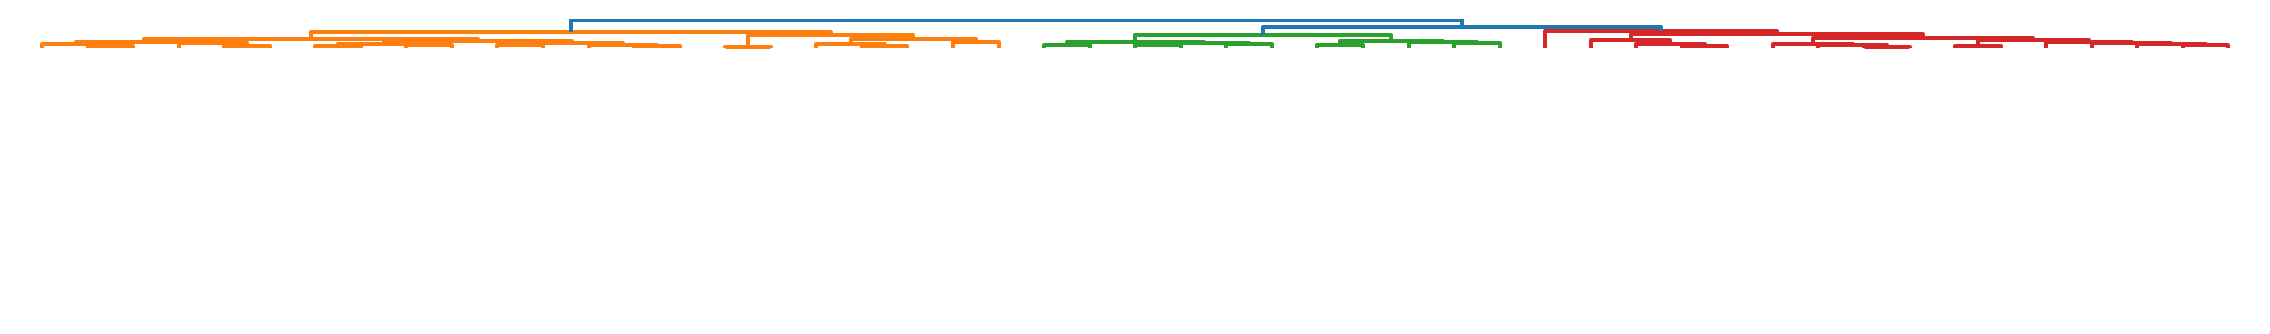

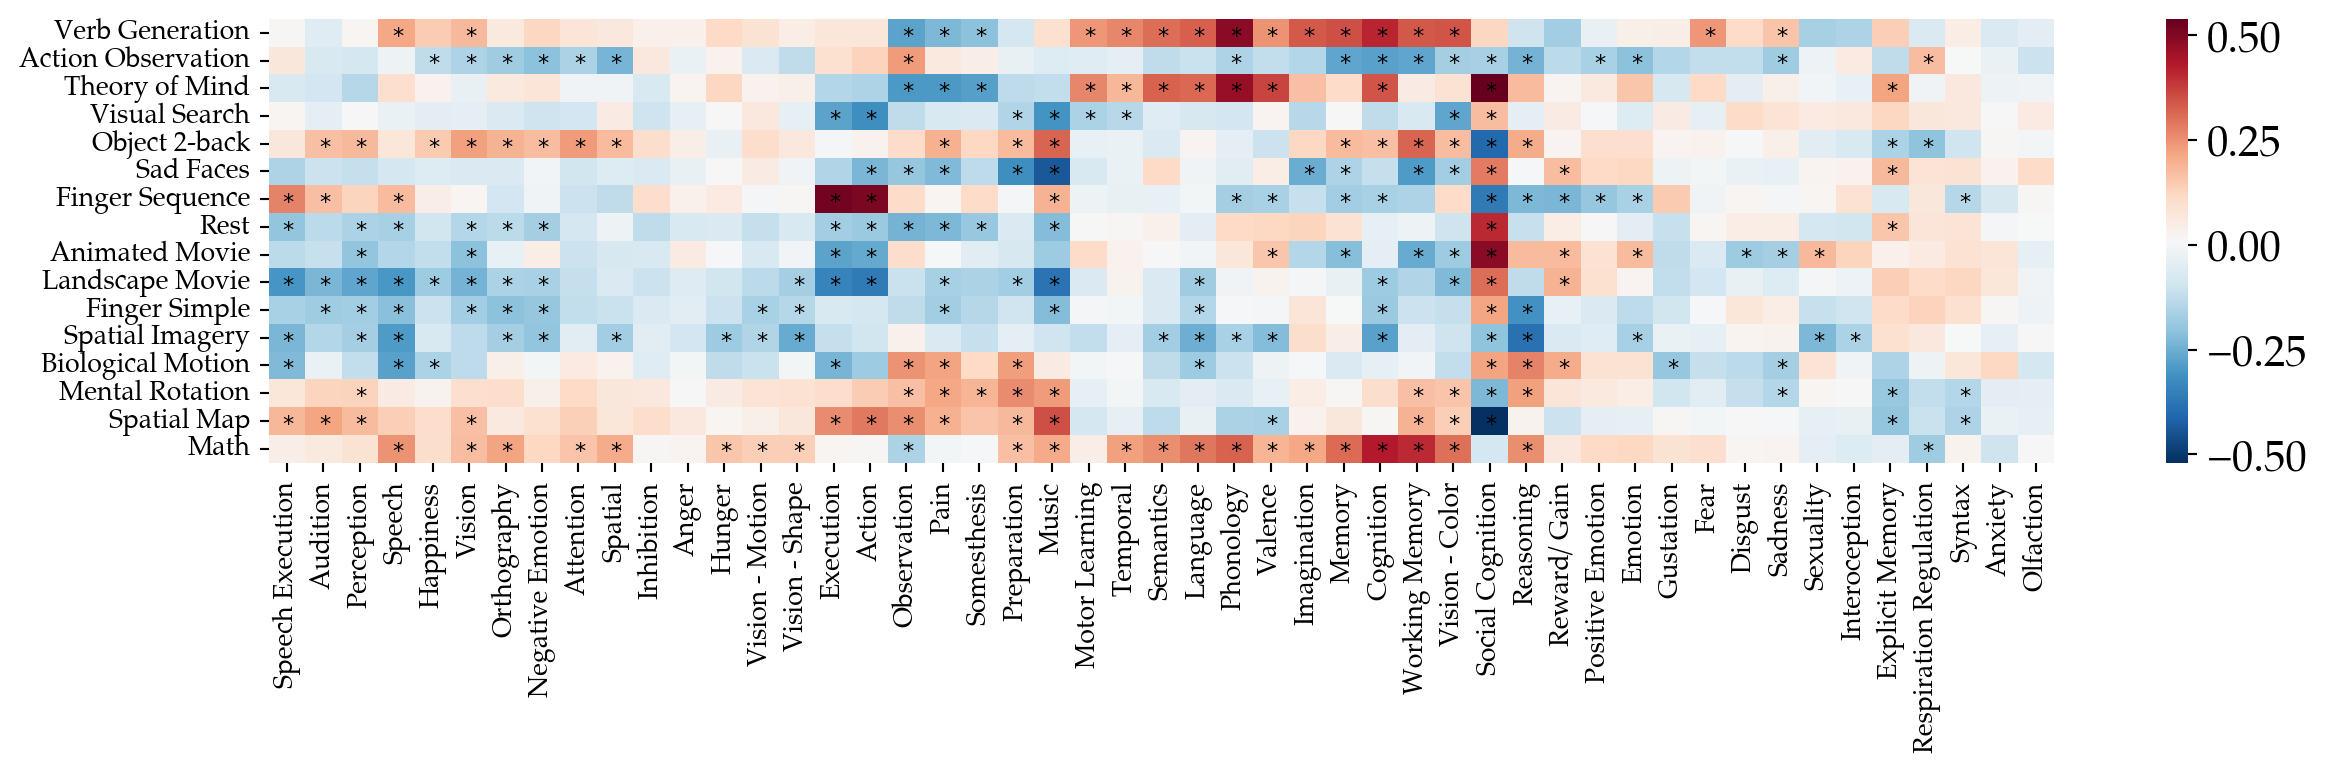

In [15]:
# Code from chatgpt

# Hierarchical clustering
model = AgglomerativeClustering(n_clusters=None, distance_threshold=0)
model.fit(r.T)

# Linkage matrix
linkage_matrix = create_linkage_matrix(model)

# Plot the dendrogram and extract the leaf order
fig, ax = plt.subplots(figsize=(15, 2))
dendro = dendrogram(linkage_matrix, show_contracted=True, ax=ax, no_labels=True)
# ax.set_title("Hierarchical Clustering Dendrogram")
# ax.set_ylabel("Distance")
ax.set_ylim([-25, ax.get_ylim()[1]])
ax.axis('off')

# extract the ordering
leaf_order = dendro['leaves']

# reorder the original data
r_reordered = r.iloc[:, leaf_order]

# plot the reordered data
fig, ax = plt.subplots(figsize=(15, 3))
sns.heatmap(r_reordered, cmap='RdBu_r',linecolor='.8', ax=ax)
ax.set_xticks(np.arange(r.shape[1])+0.5)
ax.set_xticklabels(subdomain_labels.loc[r_reordered.columns].values, rotation=90, horizontalalignment='center', fontsize=10)
ax.set_yticks(np.arange(r.shape[0])+0.5)
ax.set_yticklabels(sel_tasks_print_names, rotation=0, fontsize=10)
ax.set_ylabel('')

# add the * layer
sig = p < 0.05
sig = sig.iloc[:, leaf_order]
for x, col in enumerate(r_reordered.columns):
    for y, row in enumerate(r_reordered.index):
        if sig.loc[row, col]:
            text = r'$^*$'
            ax.text(x+0.5, y+1.0,
                    text, 
                    fontsize=12,
                    color='black',
                    horizontalalignment='center', 
                    verticalalignment='center')

# Report significance only when surviving multiple-comparison correction (FDR)

In [16]:
import statsmodels.stats.multitest
# FDR correction
sig_fdr, _ = statsmodels.stats.multitest.fdrcorrection(p.values.flatten())
# reshape 
sig_fdr = pd.DataFrame(sig_fdr.reshape(p.shape), index=p.index, columns=p.columns)
# reorder
sig_fdr = sig_fdr.iloc[:, leaf_order]

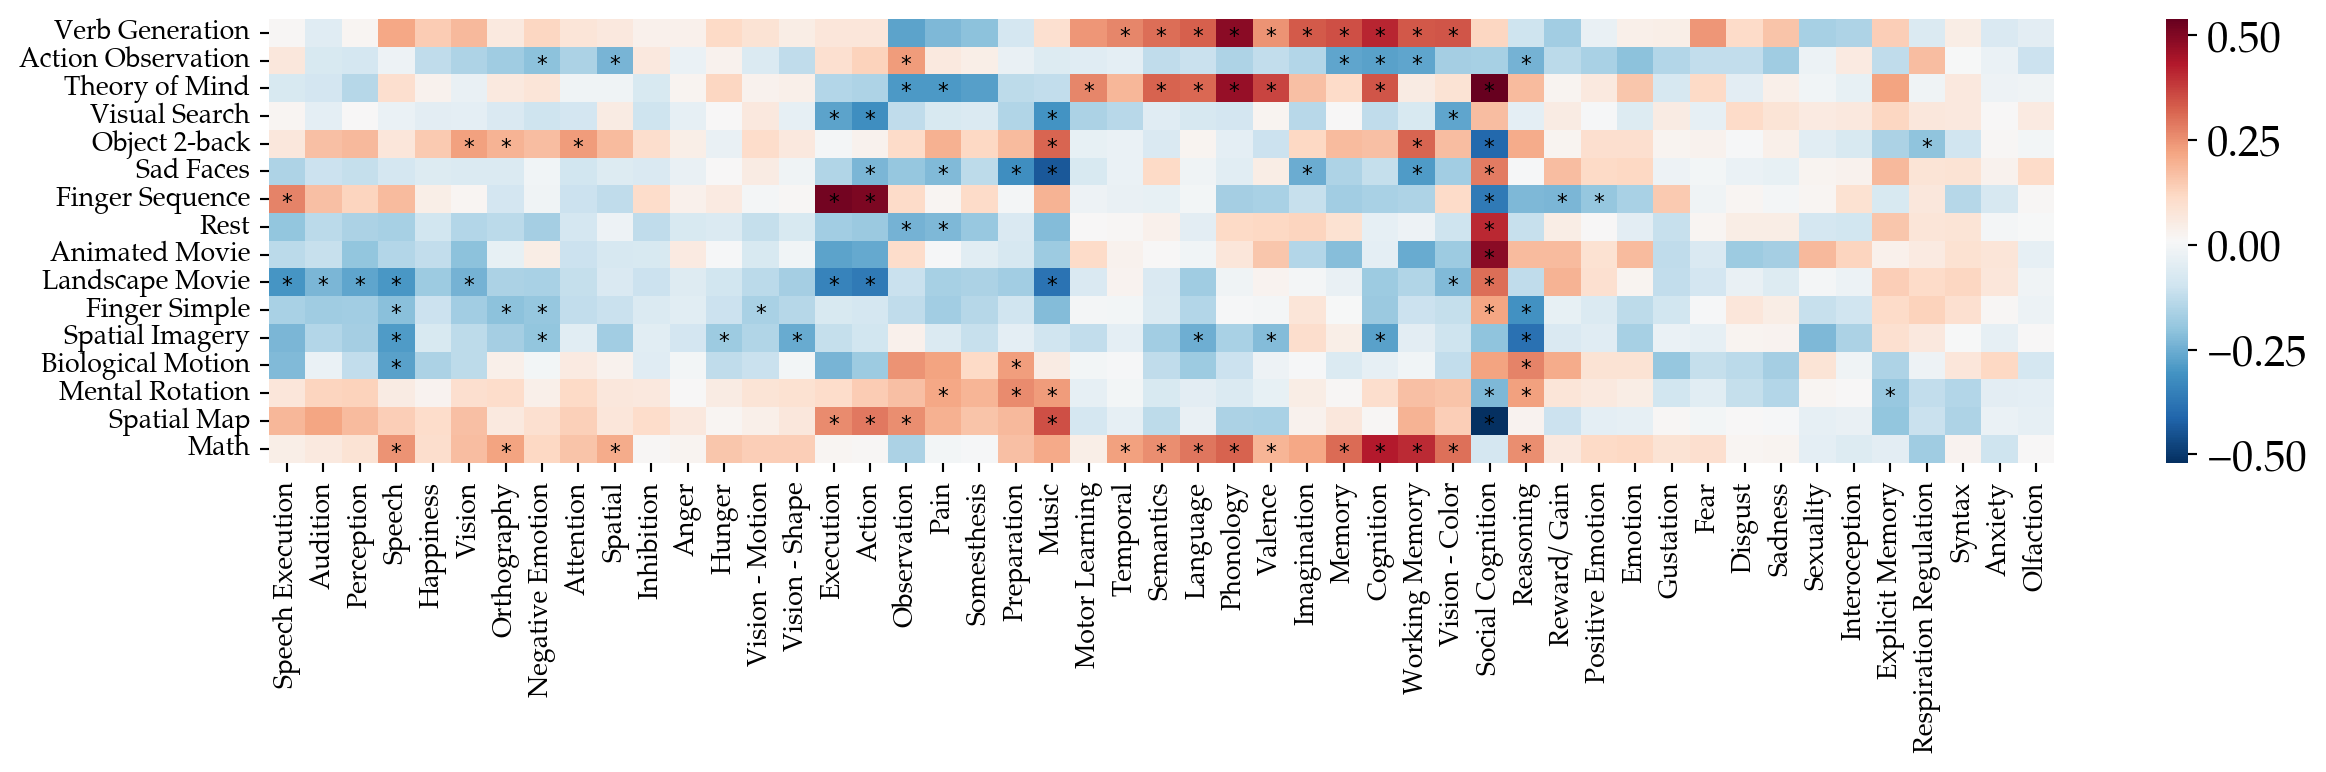

In [17]:
# plot the reordered data
fig, ax = plt.subplots(figsize=(15, 3))
sns.heatmap(r_reordered, cmap='RdBu_r',linecolor='.8', ax=ax)
ax.set_xticks(np.arange(r.shape[1])+0.5)
ax.set_xticklabels(subdomain_labels.loc[r_reordered.columns].values, rotation=90, horizontalalignment='center', fontsize=10)
ax.set_yticks(np.arange(r.shape[0])+0.5)
ax.set_yticklabels(sel_tasks_print_names, rotation=0, fontsize=10)
ax.set_ylabel('')

# add the * layer
for x, col in enumerate(r_reordered.columns):
    for y, row in enumerate(r_reordered.index):
        if sig_fdr.loc[row, col]: # USe the FDR-corrected p-values.
            text = r'$*$'
            ax.text(x+0.5, y+0.6,
                    text, 
                    fontsize=8,
                    color='black',
                    horizontalalignment='center', 
                    verticalalignment='center')

In [18]:
# Decide if you want to save the figure
fig.savefig(os.path.join(BASE_DIR, 'Figures/Comparison_parcellations/Figure4/mdtb_posneg_correlations_variogram_fdr.png'), bbox_inches='tight')

# Now on to the Nettekoven Atlas
## We use the 32-parcel csymmetrical atlas, merging the left and right parcels to ultimately create 16 parcels.

In [19]:
nettekoven_labels = pd.Series({
    '0': 'null',
    'M1L': 'Eye - left',
    'M2L': 'Mouth - left',
    'M3L': 'Hand & Upper - left',
    'M4L': 'Foot & Lower - left',
    'A1L': 'Spatial simulation - left',
    'A2L': 'Action observation - left',
    'A3L': 'Motor imagery - left',
    'D1L': 'Spatial WM - left',
    'D2L': 'Retrieval - left',
    'D3L': 'Verbal WM - left',
    'D4L': 'Spatial/ N-back - left',
    'S1L': 'Linguistic - left',
    'S2L': 'Social - left',
    'S3L': 'Rest - left',
    'S4L': 'Self-projection - left',
    'S5L': 'Scene construction - left',
    'M1R': 'Eye - right',
    'M2R': 'Mouth - right',
    'M3R': 'Hand & Upper - right',
    'M4R': 'Foot & Lower - right',
    'A1R': 'Spatial simulation - right',
    'A2R': 'Action observation - right',
    'A3R': 'Motor imagery - right',
    'D1R': 'Spatial WM - right',
    'D2R': 'Retrieval - right',
    'D3R': 'Verbal WM - right',
    'D4R': 'Spatial/ N-back - right',
    'S1R': 'Linguistic - right',
    'S2R': 'Social - right',
    'S3R': 'Rest - right',
    'S4R': 'Self-projection - right',
    'S5R': 'Scene construction - right' 
})
# We spoke to the authors and using the M1 - to - S5 naming is more appropriate. We report the labels here only for convenience.
nettekoven_labels = nettekoven_labels.index

In [20]:
nettekoven_labels_merged = nettekoven_labels[:17].str.replace('L', '')

# Plot and hierarchically cluster (L-R merged)

In [21]:
# load and label
obs_mean = pd.read_csv(os.path.join(OUTPUT_DIR, 'z_nettekoven_dseg_LRmerge_mean.csv'), index_col=0)
p = pd.read_csv(os.path.join(OUTPUT_DIR, 'z_nettekoven_dseg_LRmerge_p.csv'), index_col=0)
obs_mean.index = nettekoven_labels_merged
p.index = nettekoven_labels_merged
# drop null
obs_mean = obs_mean.drop(index='0')
p = p.drop(index='0')

In [22]:
import statsmodels.stats.multitest
# FDR correction
sig_fdr, _ = statsmodels.stats.multitest.fdrcorrection(p.values.flatten())
# reshape 
sig_fdr = pd.DataFrame(sig_fdr.reshape(p.shape), index=p.index, columns=p.columns)

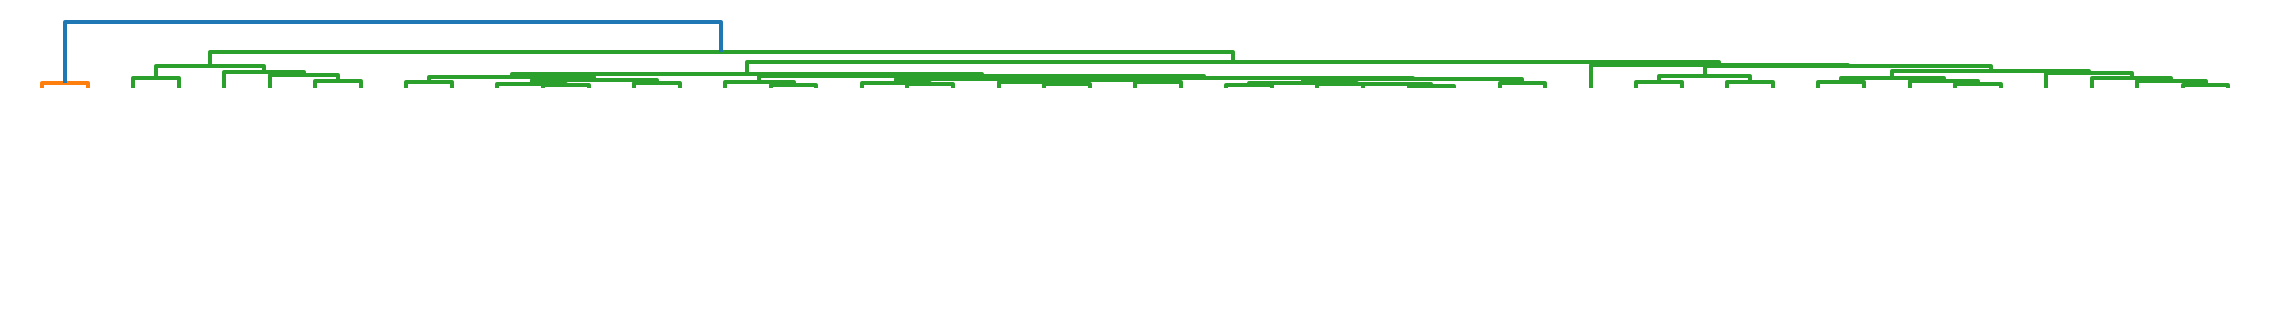

In [23]:
# hierarchical clustering
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

# hierarchical clustering
model = AgglomerativeClustering(n_clusters=None, distance_threshold=0)
model.fit(obs_mean.T)

def create_linkage_matrix(model):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)

    for i, (left_child, right_child) in enumerate(model.children_):
        count_left = 1 if left_child < n_samples else counts[left_child - n_samples]
        count_right = 1 if right_child < n_samples else counts[right_child - n_samples]
        counts[i] = count_left + count_right

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    return linkage_matrix

# linkage matrix
linkage_matrix = create_linkage_matrix(model)

# plot the dendrogram and extract the leaf order
fig, ax = plt.subplots(figsize=(15, 2))
dendro = dendrogram(linkage_matrix, show_contracted=True, ax=ax, no_labels=True)
ax.set_ylim([-25, ax.get_ylim()[1]])
ax.axis('off')

# extract the ordering
leaf_order = dendro['leaves']

# reorder the original data
mean_reordered = obs_mean.iloc[:, leaf_order]
p_reordered = p.iloc[:, leaf_order]
sig_fdr_reordered = sig_fdr.iloc[:, leaf_order]

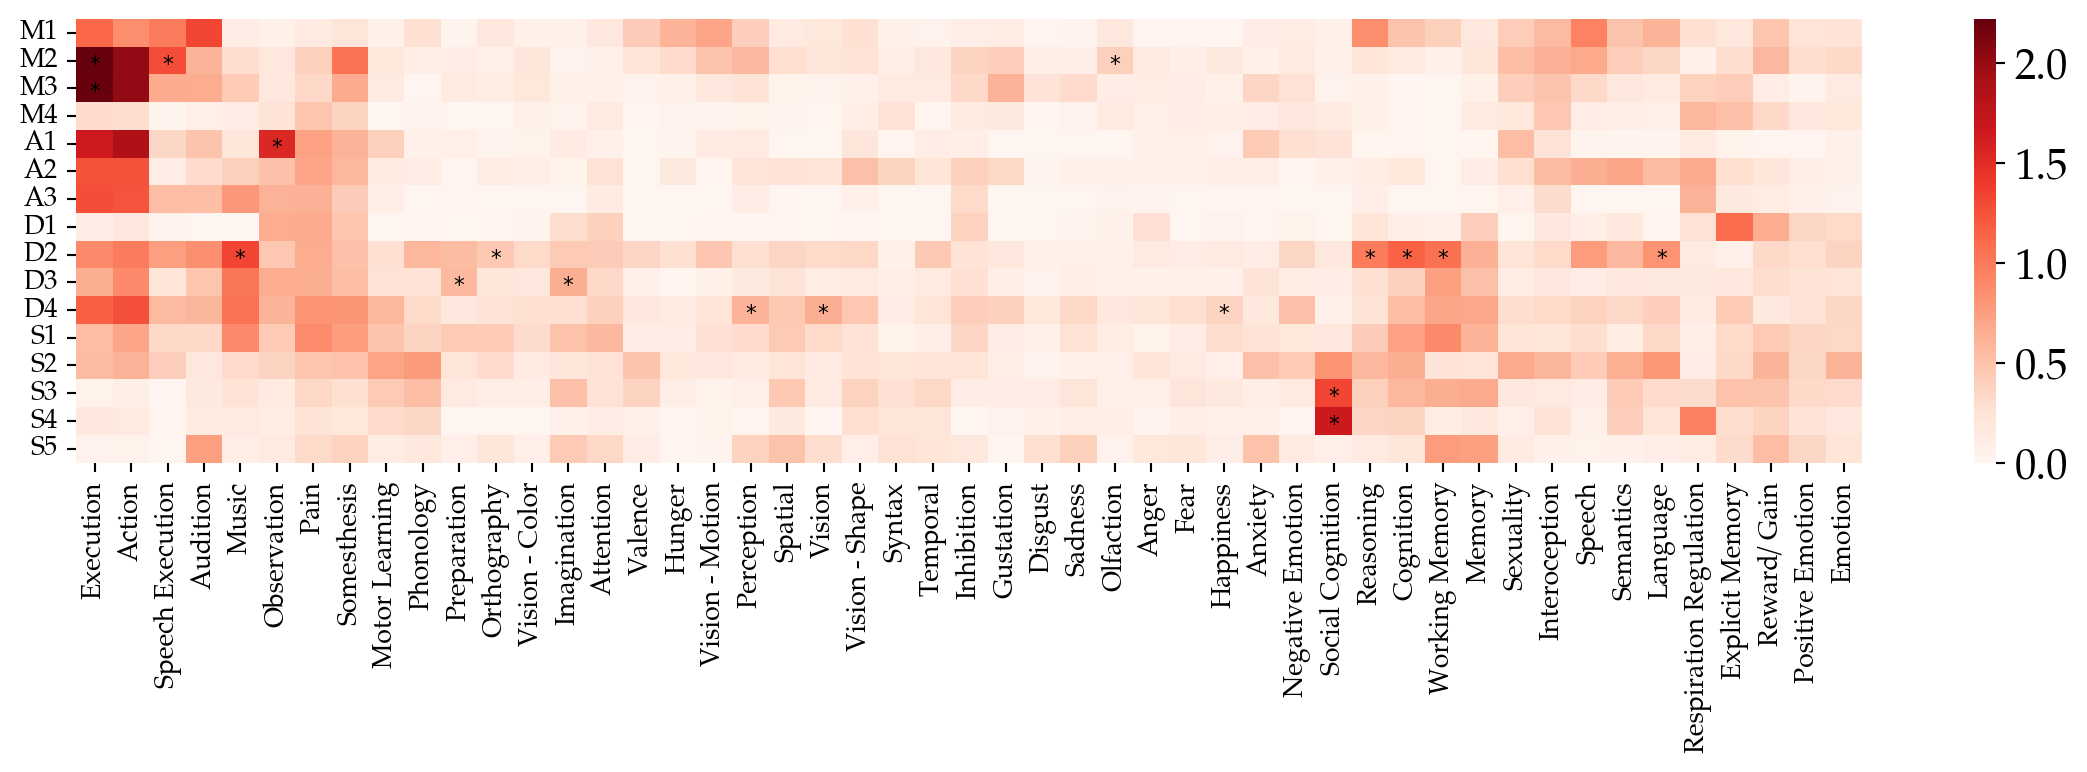

In [24]:
# plot the reordered data
fig, ax = plt.subplots(figsize=(15, 3))
sns.heatmap(mean_reordered, cmap='Reds',linecolor='.8', ax=ax)
ax.set_xticks(np.arange(p.shape[1])+0.5)
ax.set_xticklabels(subdomain_labels.loc[mean_reordered.columns].values, rotation=90, horizontalalignment='center', fontsize=10)
ax.set_yticks(np.arange(p.shape[0])+0.5)
ax.set_yticklabels(mean_reordered.index, rotation=0, fontsize=10)
ax.set_ylabel('')

# add the * layer
for x, col in enumerate(mean_reordered.columns):
    for y, row in enumerate(mean_reordered.index):
        if sig_fdr.loc[row, col]:
            text = r'$*$'
            ax.text(x+0.5, y+0.6,
                    text, 
                    fontsize=8,
                    color='black',
                    horizontalalignment='center', 
                    verticalalignment='center')

In [25]:
# Decide if you want to save the figure
fig.savefig(os.path.join(BASE_DIR, 'Figures/Comparison_parcellations/Figure4/nettekoven_dseg__LRmerge_overlap_variogram_fdr.png'), bbox_inches='tight')

# The End.